<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>TP : Machine Learning avec PySpark - Évaluation du risque de crédit 💰</strong></span></h4>

Ce TP vous permet de mettre en pratique les concepts de Machine Learning distribué en utilisant **Apache Spark**. Vous allez construire un modèle de classification pour prédire le risque de défaut de paiement de clients demandant un crédit immobilier, en utilisant un jeu de données réel.

**Objectifs pédagogiques**:
- Configurer un environnement Spark pour le machine learning
- Préparer des données en utilisant un pipeline de prétraitement efficace
- Construire et évaluer un modèle de classification avec gestion du déséquilibre de classes
- Apprendre à déployer et utiliser un modèle entraîné

---

<div class="alert alert-success">
  <strong>JEU DE DONNEES 📊📊</strong></br> Le jeu de données "Home Credit Risk Default" qui sera utilisé dans ce TP est accessible ici : <a href="https://github.com/archiducarmel/SupdeVinci_BigData_Cloud/releases/download/datas/application_train.csv">https://github.com/archiducarmel/SupdeVinci_BigData_Cloud/releases/download/datas/application_train.csv</a>
</div>

---

<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>1. Configuration de l'environnement Spark 🛠️</strong></span></h4>

Pour commencer le TP, nous devons configurer notre environnement de travail. Apache Spark est un framework de calcul distribué qui permet de traiter des volumes importants de données. Dans cette première partie, nous allons mettre en place une session Spark locale avec des paramètres optimisés pour le traitement de machine learning.

La configuration de la session Spark est cruciale car elle détermine les ressources allouées et les performances du traitement. Nous allons notamment définir la mémoire disponible pour le driver et les executors, ainsi que le nombre de partitions pour les opérations de shuffle.

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Pourquoi est-il important d'ajuster les paramètres de configuration de la session Spark lors du traitement de volumes importants de données ? Citez au moins 3 paramètres clés à prendre en compte.</span></p>

Lors du traitement de gros volumes de données, il est important d’ajuster la configuration de Spark pour optimiser les performances et éviter les erreurs de mémoire. Des paramètres clés à considérer sont par exemple : spark.executor.memory pour la mémoire allouée à chaque exécuteur, spark.executor.cores pour le nombre de cœurs utilisés, et spark.sql.shuffle.partitions pour le nombre de partitions lors des opérations de regroupement ou de jointure. Un bon réglage de ces paramètres permet d’améliorer la rapidité et la stabilité des traitements.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p>
<ol style="text-align: left; font-size: 16px; color:#0f767a">
  <li>Importer les modules nécessaires pour le machine learning avec PySpark</li>
  <li>Configurer une session Spark locale avec une mémoire adaptée</li>
</ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Documentation utile :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Configuration Spark :</span> <a href="https://spark.apache.org/docs/latest/configuration.html">https://spark.apache.org/docs/latest/configuration.html</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark ML :</span> <a href="https://spark.apache.org/docs/latest/ml-guide.html">https://spark.apache.org/docs/latest/ml-guide.html</a></p>

In [42]:
# -*- coding: utf-8 -*-
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType, FloatType, StringType, NumericType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
    StandardScaler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, when, round
from pyspark.ml.feature import Imputer

import os
import shutil

In [43]:
# Créer une session Spark locale avec une configuration personnalisée
spark = (
    SparkSession.builder
    .appName("TP2_ML")            # Nom de l'application
    .master("local[*]")           # Utiliser tous les cœurs disponibles
    .config("spark.executor.memory", "4g")   # Mémoire pour les exécutors
    .config("spark.driver.memory", "2g")     # Mémoire pour le driver
    .config("spark.sql.shuffle.partitions", "8")  # Nombre de partitions par défaut
    .getOrCreate()
)

# Vérifier la configuration active
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'TP2_ML'),
 ('spark.rdd.compress', 'True'),
 ('spark.hadoop.fs.s3a.vectored.read.min.seek.size', '128K'),
 ('spark.driver.memory', '2g'),
 ('spark.executor.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-modules=jdk.incubator.vector --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=ja

---

Maintenant que notre environnement Spark est configuré, nous allons passer à la lecture et au prétraitement des données. Spark permet de traiter efficacement de grands volumes de données, mais il est essentiel d'optimiser les opérations de lecture et de transformation.

<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>2. Chargement et exploration des données 📊</strong></span></h4>

Dans cette section, nous allons charger les données à partir d'un fichier CSV et explorer leur structure. Le jeu de données « Home Credit Default Risk » contient des informations sur les demandes de prêts immobiliers, avec une variable cible (TARGET) qui indique si le client a rencontré des difficultés de remboursement (1) ou non (0).

Nous allons d'abord charger le fichier de manière optimisée, puis explorer sa structure pour mieux comprendre les données avant de les préparer pour l'apprentissage.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p>
<ol style="text-align: left; font-size: 16px; color:#0f767a">
  <li>Charger le fichier CSV de manière optimisée avec Spark</li>
  <li>Mettre en cache le DataFrame pour améliorer les performances</li>
  <li>Afficher le schéma et un aperçu des données</li>
</ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Documentation CSV :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrameReader.csv.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrameReader.csv.html</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Optimisation avec cache :</span> <a href="https://spark.apache.org/docs/latest/rdd-programming-guide.html#which-storage-level-to-choose">https://spark.apache.org/docs/latest/rdd-programming-guide.html#which-storage-level-to-choose</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 DataFrame API :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#dataframe-apis">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.html#dataframe-apis</a></p>

In [44]:
# Charger un fichier CSV avec Spark (optimisé)
df = (
    spark.read
    .option("header", True)        # Première ligne = noms de colonnes
    .option("inferSchema", True)   # Détecte automatiquement les types
    .option("sep", ",")            # Séparateur CSV
    .csv("application_train.csv")               # Chemin du fichier à charger
)

# Réduire le nombre de partitions pour éviter un surcoût inutile
df = df.coalesce(8)  # Exemple : regrouper les partitions en 8 blocs

# Mettre le DataFrame en cache pour accélérer les traitements suivants
df.cache()

# Afficher le schéma et un aperçu
df.printSchema()
df.show(5)

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Expliquez les avantages d'utiliser les méthodes <code>coalesce()</code> et <code>cache()</code> lors du chargement de données volumineuses dans Spark. En quoi ces méthodes améliorent-elles les performances ?</span></p>

Lors du chargement de données volumineuses, la méthode coalesce() permet de réduire le nombre de partitions du DataFrame, ce qui limite le nombre de tâches à exécuter et diminue le coût de gestion des partitions (utile surtout après des opérations qui créent trop de petites partitions). La méthode cache() permet de stocker le DataFrame en mémoire, évitant ainsi de relire les données depuis le disque à chaque traitement. Ensemble, ces deux méthodes améliorent les performances en réduisant le temps d’exécution et la charge de calcul lors des traitements répétés.

---

<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>3. Préparation des données et gestion des features 🔄</strong></span></h4>

La préparation des données est essentielle dans un projet de machine learning. Elle inclut la gestion des valeurs manquantes, l'encodage des variables catégorielles et la standardisation des features numériques. Nous allons définir les colonnes par type et créer des fonctions de prétraitement adaptées.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p>
<ol style="text-align: left; font-size: 16px; color:#0f767a">
  <li>Définir les listes des colonnes numériques, catégorielles et binaires (flags)</li>
  <li>Créer une fonction pour forcer le typage des colonnes (variables catégorielle en "string" et variables numériques en <code>DoubleType</code>)</li>
</ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Types PySpark :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.html#data-types">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.html#data-types</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Transformations de colonnes :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.html#functions">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.html#functions</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 withColumn :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html</a></p>

In [45]:
# Définition des listes de colonnes par type
numeric_cols = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE"
]

categorical_cols = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "WEEKDAY_APPR_PROCESS_START",
    "ORGANIZATION_TYPE",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "WALLSMATERIAL_MODE",
    "EMERGENCYSTATE_MODE"
]

flag_cols = [
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY"
]

In [46]:
# Fonction pour forcer le typage des colonnes
def cast_columns(df, numeric_cols, categorical_cols):

    # Caster les colonnes numériques en DoubleType
    for col_name in numeric_cols:
        df = df.withColumn(col_name, df[col_name].cast(DoubleType()))

    # Caster les colonnes catégorielles en StringType
    for col_name in categorical_cols:
        df = df.withColumn(col_name, df[col_name].cast(StringType()))

    return df

# Application de la fonction sur le DataFrame
df = cast_columns(df, numeric_cols, categorical_cols)

# Vérification du schéma après typage
df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: double (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: double (nullable = true)
 |-- DAYS_EMPLOYED: double (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: double (nullable = true)
 |-- OWN_CAR_AGE: d

<h4 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>3.1 Gestion des valeurs manquantes 🔍</strong></span></h4>


<p><span>Les valeurs manquantes sont courantes dans les données réelles. Nous allons créer une fonction qui impute : la médiane pour les colonnes numériques et 'Unknown' pour les colonnes catégorielles, puis l'utiliser pour imputer</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Créer une fonction <code>impute_missing_values</code> prenant en entrée un DataFrame Spark</li> <li>Identifier dynamiquement les colonnes numériques (entiers, réels, flottants) et les colonnes catégorielles (chaînes de caractères)</li> <li>Calculer la médiane de chaque colonne numérique à l’aide de <code>percentile_approx</code>, méthode adaptée aux grands volumes de données</li> <li>Remplacer les valeurs nulles dans chaque colonne numérique par la médiane calculée</li> <li>Remplacer les valeurs nulles dans chaque colonne catégorielle par la chaîne <code>"Unknown"</code></li> <li>Tester la fonction sur un sous-ensemble de colonnes (3 numériques et 3 catégorielles) extrait du DataFrame <code>train_df</code></li> <li>Afficher le nombre de valeurs nulles par colonne avant l’imputation</li> <li>Appliquer la fonction <code>impute_missing_values</code> au DataFrame de test</li> <li>Afficher à nouveau le nombre de valeurs nulles après imputation pour vérifier que le traitement a bien été effectué</li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark DataFrame Schema :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.types.StructField.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.types.StructField.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark percentile_approx :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.percentile_approx.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.percentile_approx.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark coalesce :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.coalesce.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.coalesce.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark withColumn :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark isNull :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.isNull.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.isNull.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark filter :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark first() :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.first.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.first.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Médiane (concept statistique) :</span> <a href="https://fr.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/median/a/median-basics">https://fr.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/median/a/median-basics</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Comprendre coalesce (SQL & Spark) :</span> <a href="https://www.geeksforgeeks.org/sql-coalesce-function/">https://www.geeksforgeeks.org/sql-coalesce-function/</a></p>

In [47]:
# --- 3.1 Gestion des valeurs manquantes (version conforme aux consignes) ---

from pyspark.sql import functions as F
from pyspark.sql.types import NumericType, StringType

def impute_missing_values(df):
    # Identifier colonnes dynamiquement
    numeric_cols_dyn = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
    categorical_cols_dyn = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

    # 1) Calcul médianes via percentile_approx (adapté grands volumes)
    # (on calcule toutes les médianes en une passe via agg)
    median_exprs = [
        F.percentile_approx(F.col(c), 0.5, 10000).alias(c) for c in numeric_cols_dyn
    ]
    medians_row = df.agg(*median_exprs).first().asDict()

    # 2) Remplacer null numériques par médiane (si médiane None -> 0.0)
    for c in numeric_cols_dyn:
        med = medians_row.get(c)
        if med is None:
            print(f"Warning: Column '{c}' contains only nulls; median cannot be computed. Imputing with 0.0.")
            med = 0.0
        df = df.withColumn(
            c,
            F.when(F.col(c).isNull(), F.lit(float(med))).otherwise(F.col(c))
        )

    # 3) Remplacer null catégorielles par "Unknown"
    for c in categorical_cols_dyn:
        df = df.withColumn(
            c,
            F.when(F.col(c).isNull(), F.lit("Unknown")).otherwise(F.col(c))
        )

    return df

# --- Test demandé : 3 numériques + 3 catégorielles depuis le DF d'entraînement ---
test_num = numeric_cols[:3]
test_cat = categorical_cols[:3]

test_df = df.select(*(test_num + test_cat))

print("Avant imputation :")
for c in test_df.columns:
    print(c, test_df.filter(F.col(c).isNull()).count())

imputed_df = impute_missing_values(test_df)

print("\nAprès imputation :")
for c in imputed_df.columns:
    print(c, imputed_df.filter(F.col(c).isNull()).count())


Avant imputation :
CNT_CHILDREN 0
AMT_INCOME_TOTAL 0
AMT_CREDIT 0
NAME_CONTRACT_TYPE 0
CODE_GENDER 0
NAME_TYPE_SUITE 1292

Après imputation :
CNT_CHILDREN 0
AMT_INCOME_TOTAL 0
AMT_CREDIT 0
NAME_CONTRACT_TYPE 0
CODE_GENDER 0
NAME_TYPE_SUITE 0


<h4 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>3.2 Encodage des variables catégorielles et binaires 🔄</strong></span></h4>

<p><span>Nous allons aussi encoder les colonnes binaires (flags) en valeurs numériques (1/0) avec une fonction dédiée.</span></p>

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Créer une fonction <code>encode_binary_columns</code> prenant en argument un DataFrame Spark et une liste de colonnes binaires appelées <code>flag_cols</code></li> <li>Encoder chaque colonne binaire en remplaçant les valeurs <code>"Y"</code> ou <code>"1"</code> par <code>1</code>, et toutes les autres valeurs (y compris <code>null</code>) par <code>0</code></li> <li>Sélectionner un sous-ensemble du DataFrame original contenant uniquement les colonnes binaires à encoder</li> <li>Afficher les 5 premières lignes de ce sous-ensemble pour observer les valeurs avant encodage</li> <li>Appliquer la fonction <code>encode_binary_columns</code> à ce sous-ensemble</li> <li>Afficher à nouveau les 5 premières lignes après encodage pour vérifier la transformation</li> <li>Afficher la distribution des valeurs dans chaque colonne binaire avant encodage à l’aide de <code>groupBy</code> et <code>count</code></li> <li>Afficher la distribution des valeurs après encodage pour valider la transformation binaire</li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark when / otherwise :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.when.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.when.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark isin :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.isin.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.isin.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark withColumn :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark groupBy + count :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.count.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.count.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark orderBy :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Pourquoi encoder les variables catégorielles ? (Scikit-learn)</span> : <a href="https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features">https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Guide pratique de l’encodage binaire (Medium, FR) :</span> <a href="https://medium.com/@samuel.taleb/preprocessing-pandas-python-encoding-et-missing-values-f1a658d7dd3f">https://medium.com/@samuel.taleb/preprocessing-pandas-python-encoding-et-missing-values-f1a658d7dd3f</a></p>

In [48]:
def encode_binary_columns(df, flag_cols):
    """
    Encode des colonnes binaires en 0/1
    - accepte Y/Yes/True/1 (peu importe casse/espaces)
    - null ou autre => 0
    """
    for c in flag_cols:
        df = df.withColumn(
            c,
            F.when(
                F.lower(F.trim(F.coalesce(F.col(c).cast("string"), F.lit("")))).isin("y", "1", "yes", "true", "t"),
                F.lit(1)
            ).otherwise(F.lit(0))
        )
    return df


# -------------------------
# Sélection automatique des colonnes binaires existantes
# Ici on prend toutes les colonnes dont le nom contient "FLAG"
flag_cols = [c for c in df.columns if "FLAG" in c]

# Prendre un sous-ensemble pour l'exemple (les 5 premières)
binary_subset = df.select(flag_cols[:5])

In [49]:
# Afficher 5 premières lignes avant encodage
print("Avant encodage :")
binary_subset.show(5)

# Afficher distribution avant encodage
print("Distribution avant encodage :")
for c in binary_subset.columns:   # <- utiliser binary_subset.columns
    binary_subset.groupBy(c).count().show()

# Appliquer la fonction
encoded_df = encode_binary_columns(binary_subset, binary_subset.columns)

# Afficher 5 premières lignes après encodage
print("Après encodage :")
encoded_df.show(5)

# Afficher distribution après encodage
print("Distribution après encodage :")
for c in encoded_df.columns:      # <- utiliser encoded_df.columns
    encoded_df.groupBy(c).count().show()

Avant encodage :
+------------+---------------+----------+--------------+---------------+
|FLAG_OWN_CAR|FLAG_OWN_REALTY|FLAG_MOBIL|FLAG_EMP_PHONE|FLAG_WORK_PHONE|
+------------+---------------+----------+--------------+---------------+
|           N|              Y|         1|             1|              0|
|           N|              N|         1|             1|              0|
|           Y|              Y|         1|             1|              1|
|           N|              Y|         1|             1|              0|
|           N|              Y|         1|             1|              0|
+------------+---------------+----------+--------------+---------------+
only showing top 5 rows
Distribution avant encodage :
+------------+------+
|FLAG_OWN_CAR| count|
+------------+------+
|           N|202924|
|           Y|104587|
+------------+------+

+---------------+------+
|FLAG_OWN_REALTY| count|
+---------------+------+
|              N| 94199|
|              Y|213312|
+-------------

<h4 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>3.3 Préparation complète des données avec un pipeline 🔄</strong></span></h4>

Nous allons combiner toutes les étapes de prétraitement dans un pipeline Spark ML, ce qui permet de garantir leur application cohérente sur les données.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p>  
<ol style="text-align: left; font-size: 16px; color:#0f767a">
  <li>Créer une fonction <code>prepare_data</code> prenant en entrée un DataFrame Spark ainsi que trois listes : <code>numeric_cols</code>, <code>categorical_cols</code> et <code>flag_cols</code></li>
  <li>Convertir chaque colonne numérique au type <code>double</code> et chaque colonne catégorielle au type <code>string</code></li>
  <li>Remplacer les valeurs manquantes des colonnes catégorielles par la valeur <code>"Unknown"</code></li>
  <li>Transformer les colonnes de type drapeau (<code>flag_cols</code>) en variables binaires avec <code>1</code> pour "Y"/"1", et <code>0</code> sinon</li>
  <li>Créer un pipeline PySpark contenant les étapes suivantes :
    <ul>
      <li>Imputation des colonnes numériques (hors <code>TARGET</code>) avec la stratégie <code>median</code></li>
      <li>Encodage des colonnes catégorielles à l’aide de <code>StringIndexer</code> avec <code>handleInvalid="keep"</code></li>
      <li>Assemblage des colonnes numériques, binaires et encodées avec <code>VectorAssembler</code></li>
      <li>Standardisation du vecteur de features avec <code>StandardScaler</code> (centrage et réduction)</li>
    </ul>
  </li>
  <li>Appliquer ce pipeline au DataFrame d’origine et stocker le résultat dans une variable <code>train_prepared</code></li>
  <li>Afficher les colonnes <code>SK_ID_CURR</code>, <code>TARGET</code>, <code>features</code> et <code>scaled_features</code> pour les 3 premières lignes du DataFrame transformé</li>
  <li>Afficher le nombre total de variables utilisées dans le vecteur <code>features</code></li>
  <li>Afficher la dimension du vecteur de features obtenu après assemblage</li>
</ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Imputer (imputation de valeurs manquantes) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 StringIndexer (encodage label de chaînes) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 VectorAssembler (concaténer des colonnes en vecteur de features) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 StandardScaler (normalisation des données) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Pipeline (enchaîner les étapes ML) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html</a></p>

In [50]:
# --- 3.3 Préparation complète via Pipeline (conforme aux consignes) ---

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Imputer
from pyspark.sql import functions as F

def prepare_data(df, numeric_cols, categorical_cols, flag_cols):

    # 1) Cast des colonnes
    df = cast_columns(df, numeric_cols, categorical_cols)

    # 2) Catégorielles : null -> "Unknown" (conforme consigne)
    for c in categorical_cols:
        df = df.withColumn(c, F.when(F.col(c).isNull(), F.lit("Unknown")).otherwise(F.col(c)))

    # 3) Flags -> 0/1 (conforme consigne)
    df = encode_binary_columns(df, flag_cols)

    # 4) Pipeline
    # 4.a Imputer MEDIAN sur colonnes numériques (hors TARGET)
    imputer = Imputer(
        inputCols=numeric_cols,
        outputCols=[f"{c}__imputed" for c in numeric_cols],
        strategy="median"
    )

    # 4.b StringIndexer sur catégorielles
    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
        for c in categorical_cols
    ]

    # 4.c Assembler : numériques imputées + flags + catégorielles indexées
    assembler_inputs = [f"{c}__imputed" for c in numeric_cols] + flag_cols + [f"{c}_idx" for c in categorical_cols]
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

    # 4.d StandardScaler
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

    pipeline = Pipeline(stages=[imputer] + indexers + [assembler, scaler])

    preprocessor_model = pipeline.fit(df)
    prepared_df = preprocessor_model.transform(df)

    return prepared_df, assembler_inputs, preprocessor_model

# --- Utilisation ---
train_prepared, features_list, preprocessor_model = prepare_data(df, numeric_cols, categorical_cols, flag_cols)

train_prepared.select("SK_ID_CURR", "TARGET", "features", "scaled_features").show(3, truncate=False)
print("Nombre total de variables utilisées :", len(features_list))
print("Dimension du vecteur features :", train_prepared.select("features").first()["features"].size)


+----------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
# -----------------------------
# Exemple d'utilisation
# -----------------------------
train_prepared, features_list, preprocessor_model = prepare_data(df, numeric_cols, categorical_cols, flag_cols)

# Afficher SK_ID_CURR, TARGET, features et scaled_features pour 3 premières lignes
train_prepared.select("SK_ID_CURR", "TARGET", "features", "scaled_features").show(3, truncate=False)

# Nombre total de variables utilisées dans le vecteur features
print("Nombre total de variables utilisées :", len(features_list))

# Dimension du vecteur features après assemblage
print("Dimension du vecteur features :", train_prepared.select("features").first()["features"].size)

+----------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Expliquez les avantages d'utiliser un pipeline Spark ML par rapport à une série d'étapes de transformation séparées. Quelles sont les implications en termes de déploiement et de maintenance de modèles ?</span></p>

Un pipeline Spark ML permet de mettre toutes les étapes de préparation et de modélisation dans un seul flux, au lieu de faire chaque transformation séparément.

Avantages principaux :

Reproductible : tu peux appliquer exactement les mêmes transformations sur les nouvelles données.

Moins d’erreurs : l’ordre des étapes est garanti automatiquement.

Facile à déployer : tu peux sauvegarder et réutiliser le pipeline entier, pas juste le modèle.

Maintenance plus simple : si tu veux changer une étape, tu modifies le pipeline au même endroit, sans casser le reste.

---

<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>4. Entraînement et évaluation du modèle 🧠</strong></span></h4>

Nous allons maintenant diviser les données, entraîner un modèle de régression logistique (avec pondération des classes), et évaluer ses performances.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Diviser un DataFrame Spark <code>train_prepared</code> en deux sous-ensembles : <ul> <li><code>train_data</code> contenant 80 % des données</li> <li><code>test_data</code> contenant 20 % des données</li> <li>Utiliser le paramètre <code>seed=42</code> pour assurer la reproductibilité du split</li> </ul> </li> <li>Calculer et afficher le nombre de lignes dans chacun des deux sous-ensembles, ainsi que dans le jeu de données complet</li> <li>Afficher la proportion de lignes d’entraînement et de test en pourcentage</li> <li>Afficher la distribution de la variable cible <code>TARGET</code> dans l’ensemble d’entraînement à l’aide de <code>groupBy</code> et <code>count</code></li> <li>Afficher également la distribution de la variable cible dans l’ensemble de test, pour vérifier que les proportions entre les classes sont similaires</li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark randomSplit :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark count :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.count.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.count.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark groupBy + count :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.count.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.count.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 PySpark orderBy :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.orderBy.html</a></p>

In [52]:
# Split en train/test
train_data, test_data = train_prepared.randomSplit([0.8, 0.2], seed=42)

# Nombre de lignes
total_count = train_prepared.count()
train_count = train_data.count()
test_count = test_data.count()

print(f"Nombre total de lignes : {total_count}")
print(f"Nombre de lignes dans train_data : {train_count}")
print(f"Nombre de lignes dans test_data : {test_count}")

Nombre total de lignes : 307511
Nombre de lignes dans train_data : 245966
Nombre de lignes dans test_data : 61545


In [53]:
# Proportion en pourcentage
print(f"Proportion train : {train_count / total_count * 100:.2f}%")
print(f"Proportion test  : {test_count / total_count * 100:.2f}%")

Proportion train : 79.99%
Proportion test  : 20.01%


In [54]:
# Distribution de la variable cible TARGET dans l'ensemble d'entraînement
total_train = train_data.count()

print("\nDistribution TARGET dans train_data :")
train_data.groupBy("TARGET")\
    .count()\
    .withColumn("percentage", round(col("count") / total_train * 100, 2))\
    .show()


Distribution TARGET dans train_data :
+------+------+----------+
|TARGET| count|percentage|
+------+------+----------+
|     1| 19841|      8.07|
|     0|226125|     91.93|
+------+------+----------+



In [55]:
# Distribution de la variable cible TARGET dans l'ensemble de test
total_test = test_data.count()

print("Distribution TARGET dans test_data :")
test_data.groupBy("TARGET")\
    .count()\
    .withColumn("percentage", round(col("count") / total_test * 100, 2))\
    .show()

Distribution TARGET dans test_data :
+------+-----+----------+
|TARGET|count|percentage|
+------+-----+----------+
|     1| 4984|       8.1|
|     0|56561|      91.9|
+------+-----+----------+



<h4 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>4.1 Entraînement avec gestion du déséquilibre de classes ⚖️</strong></span></h4>

Pour traiter le déséquilibre entre classes, nous allons appliquer une pondération aux observations de la classe minoritaire dans le jeu d'entraînement, puis entraîner un modèle de régression logistique.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Créer une fonction <code>train_and_evaluate</code> qui entraîne un modèle de régression logistique avec pondération des classes sur un jeu <code>train_data</code>, et l’évalue sur un jeu <code>test_data</code></li> <li>Calculer le ratio de déséquilibre entre les classes (négatifs / positifs) à partir de la variable <code>TARGET</code></li> <li>Créer une colonne <code>class_weight</code> pour compenser le déséquilibre (pondérer la classe minoritaire)</li> <li>Initialiser un modèle <code>LogisticRegression</code> de PySpark ML en lui fournissant la colonne de features et la colonne des labels, et appliquer la pondération via <code>setWeightCol</code></li> <li>Entraîner le modèle avec la méthode <code>fit</code> sur les données pondérées</li> <li>Faire les prédictions sur le jeu de test avec <code>transform</code></li> <li>Calculer la métrique <code>AUC</code> (aire sous la courbe ROC) avec <code>BinaryClassificationEvaluator</code></li> <li>Transformer les prédictions en RDD de couples <code>(prédiction, vérité terrain)</code> et utiliser <code>MulticlassMetrics</code> pour obtenir : <ul> <li>La précision, le rappel et le F1-score pour chaque classe</li> <li>La matrice de confusion</li> </ul> </li> <li>Afficher un rapport de classification clair avec les métriques pour les classes 0 et 1</li> <li>Afficher la matrice de confusion avec les vrais positifs, faux positifs, vrais négatifs et faux négatifs</li> <li>Afficher les coefficients appris par le modèle, y compris l’interception (biais)</li> <li>Afficher les 10 premiers coefficients pour interpréter le poids de certaines variables dans la prédiction</li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Qu’est-ce que la régression logistique ? (Scikit-learn) :</span> <a href="https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression">https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Qu’est-ce que l’AUC - ROC ? (TowardsDataScience) :</span> <a href="https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5">https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Gérer le déséquilibre de classes (Kaggle Learn) :</span> <a href="https://www.kaggle.com/learn/advanced-machine-learning">https://www.kaggle.com/learn/advanced-machine-learning</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Matrice de confusion et métriques associées :</span> <a href="https://en.wikipedia.org/wiki/Confusion_matrix">https://en.wikipedia.org/wiki/Confusion_matrix</a></p>

In [56]:
# calcul du ratio pour pondérer la classe minoritaire
counts = train_data.groupBy("TARGET").count().collect()
n_neg = 0
n_pos = 0
for row in counts:
    if row['TARGET'] == 0:
        n_neg = row['count']
    else:
        n_pos = row['count']

ratio = n_neg / n_pos if n_pos > 0 else 1
print("Ratio classes 0/1 :", ratio)

# ajouter la colonne des poids
train_data = train_data.withColumn("class_weight", when(col("TARGET") == 1, ratio).otherwise(1))

# fonction pour entraîner le modèle
def train_logistic_model(train_data):
    lr = LogisticRegression(featuresCol="features", labelCol="TARGET", weightCol="class_weight", maxIter=50)
    model = lr.fit(train_data)
    return model

# entraîner le modèle
model = train_logistic_model(train_data)

# prédire sur le test
predictions = model.transform(test_data)

# calcul de l'AUC
evaluator = BinaryClassificationEvaluator(labelCol="TARGET")
auc = evaluator.evaluate(predictions)
print("AUC test :", auc)

Ratio classes 0/1 : 11.396854997227962
AUC test : 0.7415430319367415


In [57]:
# préparer les données pour MulticlassMetrics
pred_rdd = predictions.select("prediction", "TARGET").rdd.map(lambda row: (row[0], float(row[1])))
metrics = MulticlassMetrics(pred_rdd)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [58]:
# afficher précision, rappel et F1 pour chaque classe
print("Classe 0 :")
print("Précision :", metrics.precision(0.0))
print("Rappel :", metrics.recall(0.0))
print("F1 :", metrics.fMeasure(0.0))

print("Classe 1 :")
print("Précision :", metrics.precision(1.0))
print("Rappel :", metrics.recall(1.0))
print("F1 :", metrics.fMeasure(1.0))


Classe 0 :
Précision : 0.9595072599995053
Rappel : 0.6858082424285284
F1 : 0.7998927702396171
Classe 1 :
Précision : 0.15849038734728668
Rappel : 0.6715489566613162
F1 : 0.2564554440272776


In [59]:
# afficher la matrice de confusion
cm = metrics.confusionMatrix().toArray()
print("Matrice de confusion :")
print(cm)
print("TN =", cm[0,0], "FP =", cm[0,1], "FN =", cm[1,0], "TP =", cm[1,1])

Matrice de confusion :
[[38790. 17771.]
 [ 1637.  3347.]]
TN = 38790.0 FP = 17771.0 FN = 1637.0 TP = 3347.0


In [60]:
import matplotlib.pyplot as plt
import numpy as np

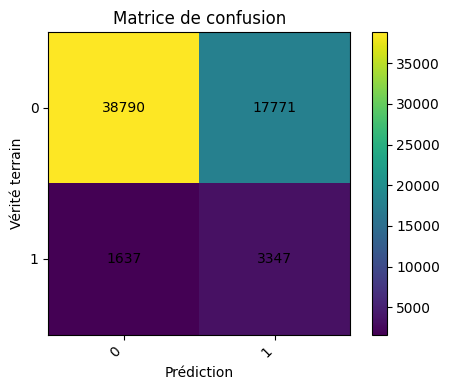

In [61]:
# récupérer la matrice de confusion
cm = metrics.confusionMatrix().toArray()

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion")
plt.colorbar()

labels = [str(i) for i in range(cm.shape[0])]
tick_marks = range(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha="right")
plt.yticks(tick_marks, labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i, j]), ha="center", va="center")

plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.tight_layout()
plt.show()

In [62]:
# afficher les coefficients du modèle
print("Intercept :", model.intercept)
print("10 premiers coefficients :", model.coefficients[:10])

Intercept : -15.714914970493924
10 premiers coefficients : [ 5.62493115e-02 -4.86360222e-07  2.56165638e-06  8.18029499e-06
 -2.98663734e-06 -1.50150703e+00  4.70547912e-06  2.51013660e-05
  1.05982057e-05  4.94417782e-05]


<p style="text-align: left; font-size: 16px; color:#7a0f43"><span>❓ Pourquoi est-il important d'appliquer une pondération aux classes dans le contexte de la détection de fraude ou d'évaluation de risque de crédit ? Quelles métriques d'évaluation sont les plus pertinentes pour ce type de problème et pourquoi ?</span></p>

Dans la détection de fraude ou l’évaluation du risque de crédit, les classes sont très déséquilibrées : la majorité des transactions ou des clients sont corrects, et seulement une petite partie correspond à la fraude ou au défaut. Sans pondération, le modèle risque de prédire systématiquement la classe majoritaire et de manquer les cas critiques de la classe minoritaire.

Appliquer une pondération aux classes permet de donner plus d’importance aux événements rares et d’améliorer la capacité du modèle à les détecter.

Les métriques les plus pertinentes sont l’AUC (aire sous la courbe ROC), la précision, le rappel et le F1-score. Le rappel est crucial pour ne pas manquer les fraudes ou défauts, la précision permet de limiter les fausses alertes, et l’AUC mesure la capacité globale du modèle à distinguer les classes, même avec un déséquilibre.

---

<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>5. Sauvegarde et application du modèle 💾</strong></span></h4>

Nous allons sauvegarder le modèle et le pipeline de prétraitement, et créer des archives pour faciliter leur distribution.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Définir les chemins d’enregistrement du préprocesseur (<code>preprocessor.spark</code>) et du modèle (<code>model.spark</code>)</li> <li>Définir les noms des fichiers ZIP à générer pour chaque objet Spark</li> <li>Vérifier si les répertoires de sauvegarde existent déjà, et les supprimer à l’aide de <code>shutil.rmtree</code> pour éviter les conflits</li> <li>Sauvegarder le pipeline de prétraitement (<code>preprocessor_model</code>) et le modèle entraîné (<code>model</code>) dans les répertoires désignés avec la méthode <code>.save()</code></li> <li>Vérifier si des archives ZIP portant les mêmes noms existent déjà, et les supprimer avec <code>os.remove</code> si besoin</li> <li>Créer deux fichiers ZIP à partir des répertoires de sauvegarde, à l’aide de <code>shutil.make_archive</code></li> <li>Afficher un message de confirmation listant les fichiers créés : <ul> <li>Les deux répertoires contenant les objets sauvegardés</li> <li>Les deux fichiers ZIP générés</li> </ul> </li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 Documentation :</span>
   <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Model.save.html">Model.save</a> |
   <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.PipelineModel.html">PipelineModel</a> |
   <a href="https://docs.python.org/3/library/shutil.html">shutil</a>
</p>

In [63]:
import os
import shutil
import zipfile

preprocessor_path = os.path.abspath("preprocessor.spark")
model_path = os.path.abspath("model.spark")

# Nettoyage si déjà présent
for p in (preprocessor_path, model_path):
    if os.path.exists(p):
        shutil.rmtree(p, ignore_errors=True)

# Sauvegarde (local)
preprocessor_model.write().overwrite().save(preprocessor_path)
model.write().overwrite().save(model_path)

print(f"[INFO] Préprocesseur sauvegardé : {preprocessor_path}")
print(f"[INFO] Modèle sauvegardé       : {model_path}")

def zipdir(path, ziph):
    base = os.path.dirname(path)
    for root, _, files in os.walk(path):
        for file in files:
            full = os.path.join(root, file)
            arc = os.path.relpath(full, start=base)
            ziph.write(full, arcname=arc)

zip_name = "spark_models.zip"
if os.path.exists(zip_name):
    os.remove(zip_name)

with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zf:
    zipdir(preprocessor_path, zf)
    zipdir(model_path, zf)

print(f"[INFO] Archive créée : {os.path.abspath(zip_name)}")

[INFO] Préprocesseur sauvegardé : /content/preprocessor.spark
[INFO] Modèle sauvegardé       : /content/model.spark
[INFO] Archive créée : /content/spark_models.zip


<h4 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>5.1 Application du modèle sur de nouvelles données 🔮</strong></span></h4>

Nous allons charger un DataFrame de test, filtrer pour un client spécifique, appliquer le prétraitement et le modèle, puis afficher la prédiction.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Charger un fichier CSV de test nommé <code>test.csv</code> dans un DataFrame Spark, en activant les options <code>header=true</code> et <code>inferSchema=true</code></li> <li>Filtrer ce DataFrame pour ne conserver que les données d’un client dont l’ID est stocké dans une variable <code>CLIENT_ID</code></li> <li>Effectuer les transformations suivantes sur les colonnes du client : <ul> <li>Caster les colonnes numériques en <code>double</code></li> <li>Caster les colonnes catégorielles en <code>string</code></li> <li>Remplacer les valeurs manquantes des colonnes catégorielles par la chaîne <code>"Unknown"</code></li> <li>Encoder les colonnes binaires (flags) en <code>0/1</code> selon les valeurs <code>"Y"</code> ou <code>"1"</code></li> </ul> </li> <li>Charger le pipeline de prétraitement sauvegardé dans le répertoire <code>preprocessor.spark</code></li> <li>Appliquer le prétraitement au DataFrame du client</li> <li>Charger le modèle de régression logistique sauvegardé dans le répertoire <code>model.spark</code></li> <li>Utiliser ce modèle pour générer une prédiction sur les données prétraitées du client</li> <li>Afficher les colonnes <code>SK_ID_CURR</code>, <code>prediction</code> et la probabilité associée à la classe <code>1</code> (défaut) à l’aide de <code>getItem(1)</code> sur la colonne <code>probability</code></li> <li>Récupérer les valeurs de prédiction et de probabilité dans des variables Python</li> <li>Afficher une synthèse de la prédiction avec : <ul> <li>La probabilité de défaut (en pourcentage)</li> <li>La classe prédite (défaut ou non)</li> <li>Un message d’interprétation : <code>Défaut de paiement probable</code> ou <code>Remboursement normal prévu</code></li> </ul> </li> </ol>

In [64]:
# --- 5.1 Application du mod?le sur de nouvelles données (flux unique) ---

from pathlib import Path
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.sql.functions import col, lit, when

# Chargement des artefacts sauvegard?s
PREPROC_PATH = Path('preprocessor.spark')
MODEL_PATH = Path('model.spark')

loaded_preproc = PipelineModel.load(str(PREPROC_PATH))
loaded_model = LogisticRegressionModel.load(str(MODEL_PATH))

# Option vector_to_array si dispo
try:
    from pyspark.ml.functions import vector_to_array
    HAS_VECTOR_TO_ARRAY = True
except Exception:
    HAS_VECTOR_TO_ARRAY = False
    from pyspark.sql.functions import udf
    from pyspark.sql.types import DoubleType
    prob1_udf = udf(lambda v: float(v[1]) if v is not None else None, DoubleType())

# 1) Charger le jeu de test
df_test = spark.read.csv('test_100.csv', header=True, inferSchema=True)

# Ajouter les colonnes manquantes attendues par le pipeline
required_cols = set(numeric_cols + categorical_cols + flag_cols)
missing_cols = [c for c in required_cols if c not in df_test.columns]
for c in missing_cols:
    df_test = df_test.withColumn(c, lit(None))

# 2) Pr?paration identique ? l'entra?nement
df_test = cast_columns(df_test, numeric_cols, categorical_cols)
df_test = impute_missing_values(df_test)
for c in categorical_cols:
    df_test = df_test.withColumn(c, when(col(c).isNull(), lit('Unknown')).otherwise(col(c)))
df_test = encode_binary_columns(df_test, flag_cols)

# 3) Application du pr?processeur + mod?le
prepared_test = loaded_preproc.transform(df_test)
predictions = loaded_model.transform(prepared_test)

# 4) Exemple : premier client tri?
client_id = df_test.select('SK_ID_CURR').orderBy(col('SK_ID_CURR')).first()['SK_ID_CURR']
client_pred = predictions.filter(col('SK_ID_CURR') == lit(client_id))

# 5) Extraction proba classe 1 + d?cision
if HAS_VECTOR_TO_ARRAY:
    result = client_pred.select(
        col('SK_ID_CURR'),
        vector_to_array(col('probability'))[1].alias('proba_target_1'),
        col('prediction').cast('int').alias('prediction')
    )
else:
    result = client_pred.select(
        col('SK_ID_CURR'),
        prob1_udf(col('probability')).alias('proba_target_1'),
        col('prediction').cast('int').alias('prediction')
    )

result = result.withColumn(
    'decision',
    when(col('prediction') == 1, lit('D?faut de paiement probable')).otherwise(lit('Remboursement normal prévu'))
)

result.show(truncate=False)

# On garde prepared_test pour les cellules suivantes (exemple spécifique)


+----------+--------------------+----------+--------------------------+
|SK_ID_CURR|proba_target_1      |prediction|decision                  |
+----------+--------------------+----------+--------------------------+
|100001.0  |2.400689164128167E-7|0         |Remboursement normal prévu|
+----------+--------------------+----------+--------------------------+



<h4 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>5.2 Analyse d'un exemple spécifique 🧮</strong></span></h4>

Nous allons examiner en détail un exemple particulier du jeu de test pour analyser la prédiction et visualiser l'impact de chaque feature.

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Sélectionner une observation spécifique du jeu de test, en prenant ici la 2<sup>e</sup> ligne du DataFrame <code>test_data</code></li> <li>Convertir cette ligne en un DataFrame Spark nommé <code>test_row_df</code> en conservant le même schéma que <code>test_data</code></li> <li>Extraire et afficher l’identifiant du client (<code>SK_ID_CURR</code>)</li> <li>Extraire et afficher la valeur réelle de la variable cible (<code>TARGET</code>) pour ce client</li> <li>Afficher une phrase descriptive indiquant s’il s’agit d’un cas de <strong>défaut de paiement</strong> ou de <strong>remboursement normal</strong> selon la valeur de la cible</li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 take(n) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.take.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.take.html</a> Permet de récupérer une liste contenant les *n* premières lignes du DataFrame. Chaque élément est un objet `Row`.</p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 createDataFrame à partir d'une ligne :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.createDataFrame.html</a> Permet de transformer une ligne unique (ou une liste de lignes) en un DataFrame Spark avec le même schéma que le jeu d’origine.</p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 select + first :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.first.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.first.html</a> Retourne la **première ligne** d’un DataFrame, utile pour accéder à une valeur spécifique.</p>

In [65]:
# --- 5.2 Exemple spécifique : 2e ligne du jeu de test ---

row = df_test.take(2)[1]
test_row_df = spark.createDataFrame([row], schema=df_test.schema)

client_id_row = row['SK_ID_CURR']
print(f'Client sélectionné : {client_id_row}')
test_row_df.show(1, truncate=False)


Client sélectionné : 100001.0
+----------+----------------+----------+-----------+------------------+---------------+------------+---------------+----------------+---------------+------------+---------------+----------+------------------------+------------+----------------+----------------+--------------+---------------+-----------+------------------+------------------------+----------------+---------------+----------+------------------+---------------+-------------------+----------------+----------------+---------------+----------------+------------+--------------------------+---------------+------------------+----------------+---------------+-----------+-------------+------------------------+---------------+----------------+-----------------+---------------+-------------------+---------------+----------------------+----------------+----------------+------------+---------------+-----------------+----------+----------------+----------------+--------------------------+-----------------+

<p style="text-align: left; font-size: 16px; color:#0f767a"><span>🖥️ Écrivez le code permettant de :</span></p> <ol style="text-align: left; font-size: 16px; color:#0f767a"> <li>Appliquer le modèle de régression logistique (<code>model</code>) sur l'exemple <code>test_row_df</code> sélectionné précédemment</li> <li>Extraire la classe prédite (<code>prediction</code>) et la probabilité de défaut à partir de la colonne <code>probability</code></li> <li>Afficher la prédiction avec un message indiquant : <ul> <li>La classe prédite (défaut de paiement ou remboursement normal)</li> <li>La probabilité de défaut exprimée en pourcentage</li> </ul> </li> <li>Extraire : <ul> <li>Le vecteur de coefficients du modèle</li> <li>Le vecteur de features du client</li> <li>Le produit <code>coefficient × valeur</code> pour chaque feature</li> </ul> </li> <li>Créer un DataFrame <code>contribution_df</code> contenant : <ul> <li>Le nom de chaque feature</li> <li>Sa valeur, son coefficient et sa contribution à la prédiction</li> </ul> </li> <li>Afficher les 5 features ayant la plus grande contribution positive (celles qui augmentent le risque de défaut)</li> <li>Afficher les 5 features ayant la plus grande contribution négative (celles qui réduisent le risque)</li> <li>Comparer la classe prédite à la valeur réelle (<code>actual_target</code>) et afficher si la prédiction est correcte ou non</li> <li>Afficher les valeurs réelles de certaines variables explicatives clés (par exemple : <code>AMT_INCOME_TOTAL</code>, <code>DAYS_BIRTH</code>, <code>CODE_GENDER</code>, etc.) pour enrichir l’analyse du profil client</li> </ol>

<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 transform (inférence avec un modèle ML) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Model.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Model.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 getItem – accéder à un élément d’un vecteur :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.getItem.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.getItem.html</a></p>
<p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 coefficients du modèle (logistique linéaire) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionModel.coefficients.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionModel.coefficients.html</a></p> <p style="text-align: left; font-size: 16px; color:#ec8f1a"><span>📚 scaled_features (vecteur des variables standardisées) :</span> <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html">https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html</a></p>

In [66]:
# --- 5.3 Pr?diction sur l'exemple s?lectionn? ---

test_row_prepared = loaded_preproc.transform(test_row_df)
pred_single = loaded_model.transform(test_row_prepared)

if HAS_VECTOR_TO_ARRAY:
    single_res = pred_single.select(
        col('SK_ID_CURR'),
        vector_to_array(col('probability'))[1].alias('proba_target_1'),
        col('prediction').cast('int').alias('prediction')
    )
else:
    single_res = pred_single.select(
        col('SK_ID_CURR'),
        prob1_udf(col('probability')).alias('proba_target_1'),
        col('prediction').cast('int').alias('prediction')
    )

single_res = single_res.withColumn(
    'decision',
    when(col('prediction') == 1, lit('D?faut de paiement probable')).otherwise(lit('Remboursement normal pr?vu'))
)

single_res.show(truncate=False)


+----------+--------------------+----------+--------------------------+
|SK_ID_CURR|proba_target_1      |prediction|decision                  |
+----------+--------------------+----------+--------------------------+
|100001.0  |2.400689164128167E-7|0         |Remboursement normal pr?vu|
+----------+--------------------+----------+--------------------------+



---

<h4 style="text-align: left; color:#20a08d; font-size: 25px"><span><strong>7. Conclusion et bonnes pratiques 📝</strong></span></h4>

Dans ce TP, nous avons parcouru toutes les étapes clés du machine learning distribué avec PySpark, depuis la configuration du cluster jusqu'à l'analyse détaillée d'une prédiction et la sauvegarde du modèle.

Les points majeurs sont :
- Configuration optimisée de Spark
- Chargement et prétraitement des données volumineuses
- Construction d'un pipeline robuste
- Gestion du déséquilibre des classes
- Entraînement, évaluation et sauvegarde du modèle
- Application du modèle sur de nouvelles données

Ces techniques permettent de construire des solutions de scoring de crédit efficaces et évolutives en production.